In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import sys
import lmfit
sys.path.append("..")
import hydropt.iops as iops;
import hydropt.hydropt as hd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

../hydropt/iops.py:39: UserWarning: changed interpolation method
  warnings.warn('changed interpolation method')
../hydropt/iops.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pico_siop.loc[710,:] = [0,0]
../hydropt/iops.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nano_siop.loc[710,:] = [0,0]
../hydropt/iops.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  micro_siop.loc[710,:] = [0,0]


In [17]:
plt.style.use('bmh')

In [18]:
sensors = {
    'seawifs': np.array([412, 443, 490, 510, 555, 670]),
    'meris': np.array([412.5, 442.5, 490, 510, 620, 560, 665, 681.25, 708.75]),
    'olci': np.array([400, 412.5, 442.5, 490, 510, 560, 620, 665, 673.75, 681.25, 708.75]),
    'pace': np.arange(400, 711, 5)
}

In [19]:
# load Rrs - IOP dataset
ds = xr.load_dataset('./data/psc_rrs_iop.nc')

In [24]:
# interpolate rrs to olci wavebands
ds_olci = ds.interp(wavelength=sensors.get('olci'))

In [25]:
# interpolate rrs to olci wavebands
ds_seawifs = ds.interp(wavelength=sensors.get('seawifs'))

In [26]:
# interpolate rrs to meris wavebands
ds_meris = ds.interp(wavelength=sensors.get('meris'))

### Bio-optical models

In [27]:
def waveband_wrapper(f, **kwargs_out):
    def inner(*args, **kwargs_in):
        kwargs_in.update(kwargs_out)
        return f(*args, **kwargs_in)
    return inner

In [28]:
# siop for phytoplankton
aph_s = pd.read_csv('../hydropt/data/psc_absorption_se_uitz_2008.csv',
                    index_col='wavelength')

In [29]:
# chl. specific absorption for psc's
a_size_classes = {
    'pace': iops.interpolate_to_wavebands(aph_s, sensors.get('pace')),
    'olci': iops.interpolate_to_wavebands(aph_s, sensors.get('olci')),
    'seawifs': iops.interpolate_to_wavebands(aph_s, sensors.get('seawifs')),
    'meris': iops.interpolate_to_wavebands(aph_s, sensors.get('meris'))
}

../hydropt/iops.py:39: UserWarning: changed interpolation method
  warnings.warn('changed interpolation method')


In [30]:
def pico(*args, wb, a_star):
    '''
    pico IOP model
    
    chl - concentration in mg/m3
    '''
    def iop(chl=args[0]):
        # chl specific absorption 
        a_st = a_star
        bb_star = .0038*(wb/470)**-1.4

        return chl*np.array([a_st.reshape(-1), bb_star])
    
    def gradient(*args):
        d_a = a_star
        d_bb = .0038*(wb/470)**-1.4

        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

def nano(*args, wb, a_star):
    '''
    nano IOP model
    
    chl - concentration in mg/m3
    '''
    def iop(chl=args[0]):
        # chl specific absorption 
        a_st = a_star
        bb_star = .0038*(wb/470)**-1.4

        return chl*np.array([a_st.reshape(-1), bb_star])

    def gradient(*args):
        d_a = a_star
        d_bb = .0038*(wb/470)**-1.4

        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

def micro(*args, wb, a_star):
    '''
    micro IOP model
    
    chl - concentration in mg/m3
    '''
    def iop(chl=args[0]):
        # chl specific absorption 
        a_st = a_star
        bb_star = .0004*(wb/470)**.4

        return chl*np.array([a_st.reshape(-1), bb_star])
    
    def gradient(*args):
        d_a = a_star
        d_bb = .0004*(wb/470)**.4

        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

In [31]:
def detrital_matter(*args, wb):
    '''
    IOP model for detrital matter
    '''
    # vectorized
    def iop(spm=args[0]):
        a = np.exp(-.0123*(wb-440))
        bb = (.21*spm**-.21)*(550/wb)
       #bb = .5*(550/wbands_hs)
        
        return spm*np.array([a, bb])
    
    def gradient(spm=args[0]):
        d_a = np.exp(-.0123*(wb-440))
        d_bb = .21*.79*spm**-.21*(550/wb)
        
        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

In [32]:
def cdom(*args, wb):
    '''
    IOP model for CDOM
    '''
    def iop(a_440=args[0]):
        a = a_440*np.exp(-0.0177*(wb-440))
        bb = np.zeros(len(wb))
        
        return np.array([a, bb])
    
    def gradient(*args):
        d_a = np.exp(-0.0177*(wb-440))
        d_bb = np.zeros(len(wb))
        
        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

In [33]:
def bio_optical_model(sensor):
    bom = iops.BioOpticalModel()
    bom.set_iop(sensors.get(sensor),              
              cdom = waveband_wrapper(cdom, wb=sensors.get(sensor)),
              dm = waveband_wrapper(detrital_matter, wb=sensors.get(sensor)),
              pico = waveband_wrapper(pico, wb=sensors.get(sensor), a_star=a_size_classes.get(sensor).pico.values),
              nano = waveband_wrapper(nano, wb=sensors.get(sensor), a_star=a_size_classes.get(sensor).nano.values),
              micro = waveband_wrapper(micro, wb=sensors.get(sensor), a_star=a_size_classes.get(sensor).micro.values))
    
    return bom

### Inversion

In [34]:
#pace
inverse_pace = hd.InversionModel(
    fwd_model=hd.PolynomialForward(bio_optical_model(sensor='pace')),
    minimizer=lmfit.minimize)
#olci
inverse_olci = hd.InversionModel(
    fwd_model=hd.PolynomialForward(bio_optical_model(sensor='olci')),
    minimizer=lmfit.minimize)
#seawifs
inverse_seawifs = hd.InversionModel(
    fwd_model=hd.PolynomialForward(bio_optical_model(sensor='seawifs')),
    minimizer=lmfit.minimize)

#meris
inverse_meris = hd.InversionModel(
    fwd_model=hd.PolynomialForward(bio_optical_model(sensor='meris')),
    minimizer=lmfit.minimize)

In [35]:
# set initial guess parameters close to measured values
x0 = lmfit.Parameters()
#3 comp model
x0.add('cdom', value=.02, min=1E-9)
x0.add('dm', value=.05, min=1E-9)
x0.add('pico', value=.6, min=1E-9)
x0.add('nano', value=.6, min=1E-9)
x0.add('micro', value=.6, min=1E-9)

In [36]:
x_hat_olci = ds_olci.rrs.groupby('no').apply(inverse_olci.invert, x=x0)

../hydropt/hydropt.py:309: UserWarning: no band transformation is applied to jacobian -
         o.k. when band_model = 'rrs' 
  o.k. when band_model = 'rrs' ''')


In [37]:
x_hat_pace = ds.rrs.groupby('no').apply(inverse_pace.invert, x=x0)

In [38]:
x_hat_seawifs = ds_seawifs.rrs.groupby('no').apply(inverse_seawifs.invert, x=x0)

In [39]:
x_hat_meris = ds_meris.rrs.groupby('no').apply(inverse_meris.invert, x=x0)

In [40]:
def filter_relative_error(x, threshold):
    '''
    x: xarray.Dataset()
    threshold: maximum relative error
    '''
    x['r_error'] = x.std_error/x.conc
    # filter retrievals with relative error > 200%
    x['conc'] = x.conc.where(x.r_error<threshold)
    x['iops'] = x.iops.where(x.r_error<threshold)
    
    return x

In [41]:
x_hat_pace = filter_relative_error(x_hat_pace, threshold=2)

In [42]:
x_hat_olci = filter_relative_error(x_hat_olci, threshold=2)

In [43]:
x_hat_seawifs = filter_relative_error(x_hat_seawifs, threshold=2)

In [44]:
x_hat_meris = filter_relative_error(x_hat_meris, threshold=2)

### Regression statistics

In [45]:
def mean_normalised_bias(x, y):
    return np.sum((y-x)/x)/len(x)

def mean_bias(x, y):
    return np.sum(y-x)/len(x)

In [46]:
def regression_stats(x, y):
    '''
    x: ground truth
    y: retrieved
    '''
    # mask nans
    mask = ~np.any([np.isnan(y), y==0], axis=0)
    n = len(x)
    x = x[mask]
    y = y[mask]
    # log transform
    x_log, y_log = np.log10(x), np.log10(y)
    # stats
    r2 = r2_score(x_log, y_log)
    # log transform according to Seegers et al. 2018
    mae = np.power(10, mean_absolute_error(x_log, y_log))
    mb = np.power(10, mean_bias(x_log, y_log))
    # fit linear model
    lm = LinearRegression().fit(
        np.reshape(x_log, (-1,1)),
        np.reshape(y_log, (-1,1)))
    slope = lm.coef_[0][0]
    intercept = lm.intercept_[0]
    stats = {
        'r2': r2,
        'mae': mae,
        'mb': mb,
        'slope': slope,
        'intercept': intercept,
        'f': len(x)/n}
    
      
    return stats
    

In [47]:
# olci stats
olci_stats = regression_stats(ds_olci.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1).values,
                              x_hat_olci.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1).values)

In [48]:
# pace stats
pace_stats = regression_stats(ds.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1).values,
                              x_hat_pace.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1).values)

In [49]:
# seawifs stats
seawifs_stats = regression_stats(ds_seawifs.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1).values,
                              x_hat_seawifs.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1).values)

In [50]:
# meris stats
meris_stats = regression_stats(ds_meris.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1).values,
                              x_hat_meris.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1).values)

In [80]:
stats = pd.DataFrame({
    'olci': olci_stats,
    'seawifs': seawifs_stats,
    'meris': meris_stats,
    'pace': pace_stats})

In [81]:
stats = stats.drop('intercept')

In [82]:
#transform statistics to 0-1 range according to: y=max(0, 1-abs(x-1)) -> negative values will be truncated 0
stats.loc[['mae', 'mb', 'slope']] = stats.loc[['mae', 'mb', 'slope']].apply(lambda x: np.maximum(0, 1-abs(x-1)), axis=1)

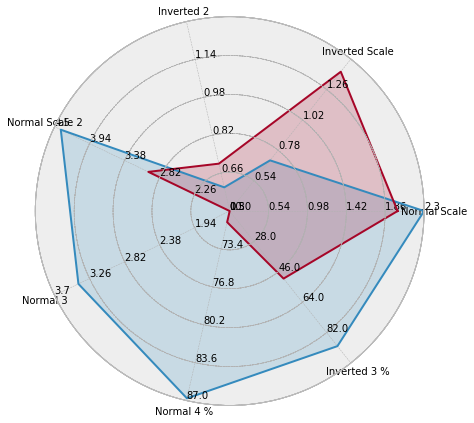

In [83]:
import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

# example data
variables = ("Normal Scale", "Inverted Scale", "Inverted 2", 
            "Normal Scale 2", "Normal 3", "Normal 4 %", "Inverted 3 %")
data = (2.3, 1.1, 1.2, 
        4.4, 3.4, 86.8, 20)
data2 = (2, .4, 1.1, 
        3, 1.5, 71, 60)
ranges = [(0.1, 2.3), (1.5, 0.3), (1.3, 0.5),
         (1.7, 4.5), (1.5, 3.7), (70, 87), (100, 10)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.plot(data2)
radar.fill(data, alpha=0.2)
radar.fill(data2, alpha=0.2)

plt.show()    

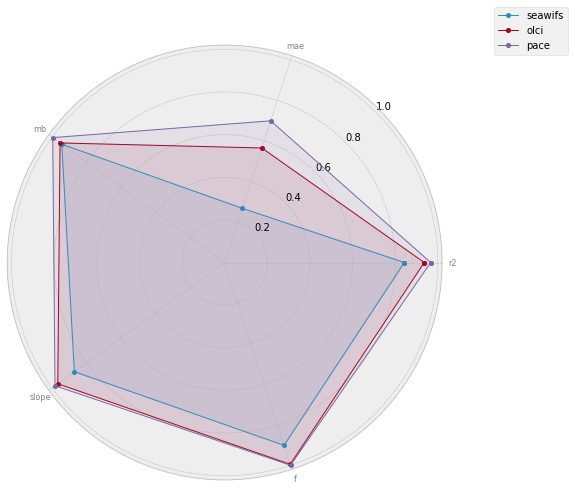

In [92]:
from math import pi
 
# Set data
df = stats[['seawifs', 'olci', 'pace']]
 
# number of variables
categories=list(df.index)
N = len(df)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.values
values = np.append(values, np.array([values[0]]), axis=0)
# values += values[:1]
# values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
#ax = plt.subplot(111, polar=True)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(45)
#plt.yticks([0, 1], ["0","1"], color="grey", size=7)
plt.ylim(0,1.02)
 
# Plot data
for i,j in zip(df.columns, values.T):
    ax.plot(angles, j, linewidth=1, linestyle='solid', marker='o', markersize=4, label=i)
    ax.fill(angles, j, alpha=0.1)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
# Show the graph
plt.show()